In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler

# Funções Úteis

In [2]:
def create_correlation_matrix(
    df: pd.DataFrame, 
    columns: list[str],
    additional_title: str = ""):

    """
    Creates a correlation matrix for the given DataFrame.

    Parameters
    ----------
    df: pd.DataFrame
        The input DataFrame to calculate the correlation matrix for.
    columns: list[str]
        The list of column names to include in the correlation matrix.
    additional_title: str, optional
        An additional title to add to the correlation matrix plot, by default "".
    """

    corr_matrix = df.corr().values
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=True, xticklabels=columns, yticklabels=columns, cmap="YlGnBu", cbar=True)
    plt.title(f"Correlação entre Variáveis {additional_title}")
    plt.show()

In [3]:
def plot_scatterplot(
    df: pd.DataFrame,
    x: str,
    y: str,
    hue: str = None):

    fig, ax = plt.subplots(figsize=(16, 8))
    sns.scatterplot(data=df, x=x, y=y, hue=hue, ax=ax)

    ax.set_title('')
    ax.grid(False)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')

    ax.set_xlabel(x, fontsize=11, fontname='Arial', color='black')
    ax.set_ylabel(y, fontsize=11, fontname='Arial', color='black')

    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()

# Coleta de Dados

In [4]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/processed")

In [5]:
complete_data = pd.read_csv(join(DATA_PATH, "complete_df.csv"))

C:\Users\testd\AppData\Local\Temp\ipykernel_26204\1464963469.py:1: DtypeWarning: Columns (23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  complete_data = pd.read_csv(join(DATA_PATH, "complete_df.csv"))


# Pré-Processamento

In [6]:
complete_data["data"] = pd.to_datetime(complete_data["data"])

In [7]:
feature_cols = [feature for feature in complete_data.columns if feature not in ["id_estacao", "data", "ano", "mes"]]
numerical_cols = [feature for feature in feature_cols if complete_data[feature].dtype in ["float64"]]
categorical_cols = [feature for feature in feature_cols if complete_data[feature].dtype in ["int64", "object"]]

numerical_data = complete_data.groupby(by=["ano", "mes", "data"])[numerical_cols].mean().reset_index()

In [8]:
complete_data = numerical_data.merge(
    complete_data[["data"] + categorical_cols].drop_duplicates(),
    how="left",
    on="data")

In [9]:
complete_data.head()

ano  mes       data  precipitacao_total_soma  pressao_atm_hora_media  \
0  2009    1 2009-01-01                 3.417582              969.900898   
1  2009    1 2009-01-02                 6.923077              968.848102   
2  2009    1 2009-01-03                10.432967              967.374452   
3  2009    1 2009-01-04                 5.701099              968.252894   
4  2009    1 2009-01-05                 5.127473              969.475869   

   pressao_atm_max_media  pressao_atm_min_media  radiacao_global_media  \
0             970.200467             969.610864            2525.011264   
1             969.179366             968.582621            2344.796465   
2             967.699560             967.069294            2205.103658   
3             968.520717             967.927428            2196.275462   
4             969.742467             969.212681            2221.737517   

   temperatura_bulbo_hora_media  temperatura_orvalho_hora_media  ...  \
0                     25.206729                       20.251157  ...   
1                     24.742439                       20.038973  ...   
2                     23.953602                       19.699686  ...   
3                     23.295086                       18.676527  ...   
4                     23.009149                       17.906149  ...   

   vento_rajada_max_media  vento_velocidade_media  categoria_El Ninõ  \
0                4.961552                2.097972                  0   
1                5.335012                2.234782                  0   
2                6.246344                2.654809                  0   
3                5.862384                2.531787                  0   
4                4.698234                1.967523                  0   

   categoria_La Ninã  categoria_Neutro   CO  MP10  MP2.5   O3  SO2  
0                  1                 0  NaN   NaN    NaN  NaN  NaN  
1                  1                 0  NaN   NaN    NaN  NaN  NaN  
2                  1                 0  NaN   NaN    NaN  NaN  NaN  
3                  1                 0  NaN   NaN    NaN  NaN  NaN  
4                  1                 0  NaN   NaN    NaN  NaN  NaN  

[5 rows x 27 columns]

In [10]:
complete_data.shape

(5844, 27)

In [11]:
complete_data.to_csv(f"{MODULE_PATH}/sources/processed/mean_complete_df.csv", index=False)

# Análise Exploratória

## Desvio Padrão

In [12]:
scaler = StandardScaler()
complete_data_scl = scaler.fit_transform(complete_data[numerical_cols])

complete_data_scl = pd.DataFrame(complete_data_scl, columns=numerical_cols)
complete_data_scl["dia_do_ano"] = (pd.to_datetime(complete_data.reset_index()["data"]).dt.day_of_year).astype(str)
complete_data_scl["ano"] = complete_data["ano"].astype(str)
complete_data_scl.set_index(["ano", "dia_do_ano"], inplace=True)

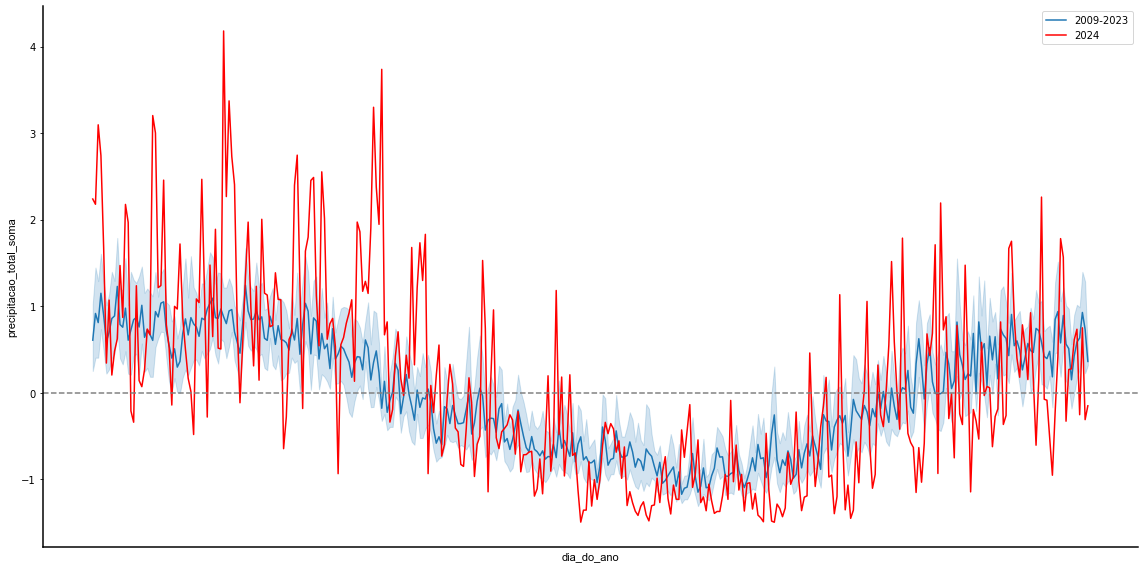

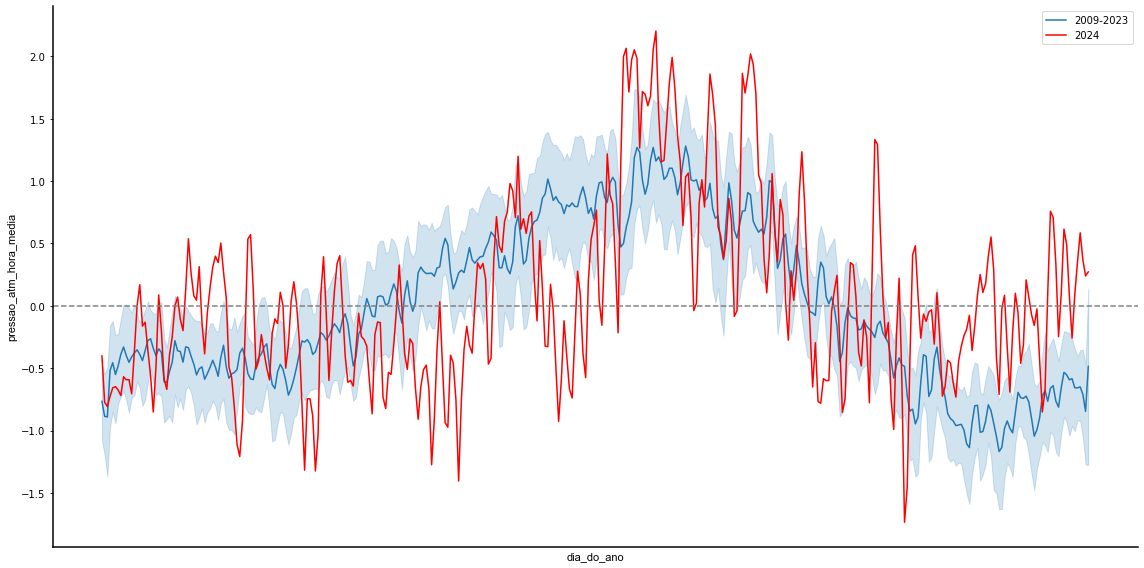

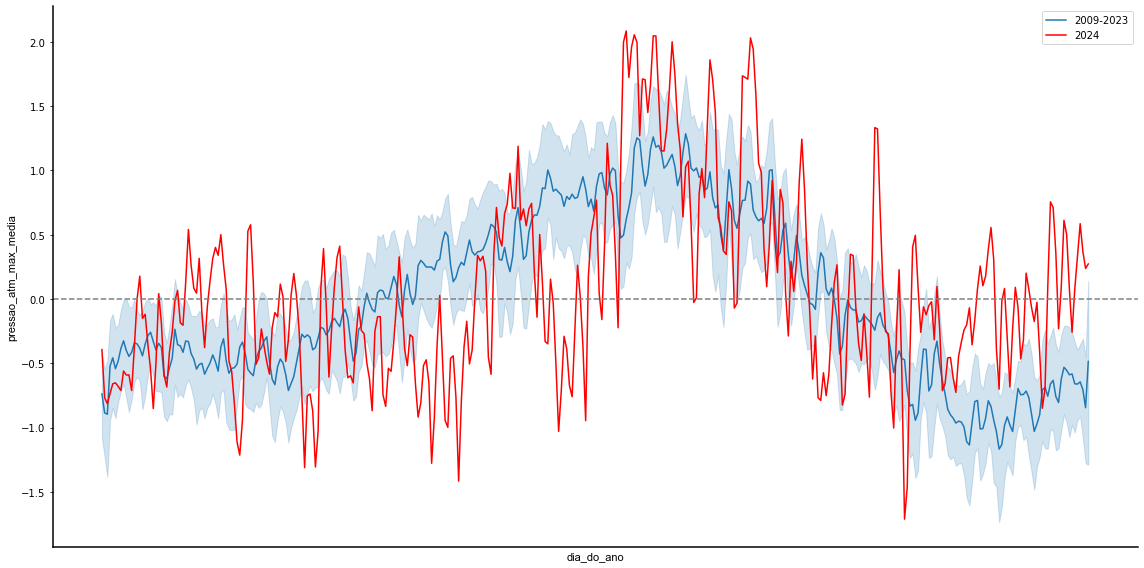

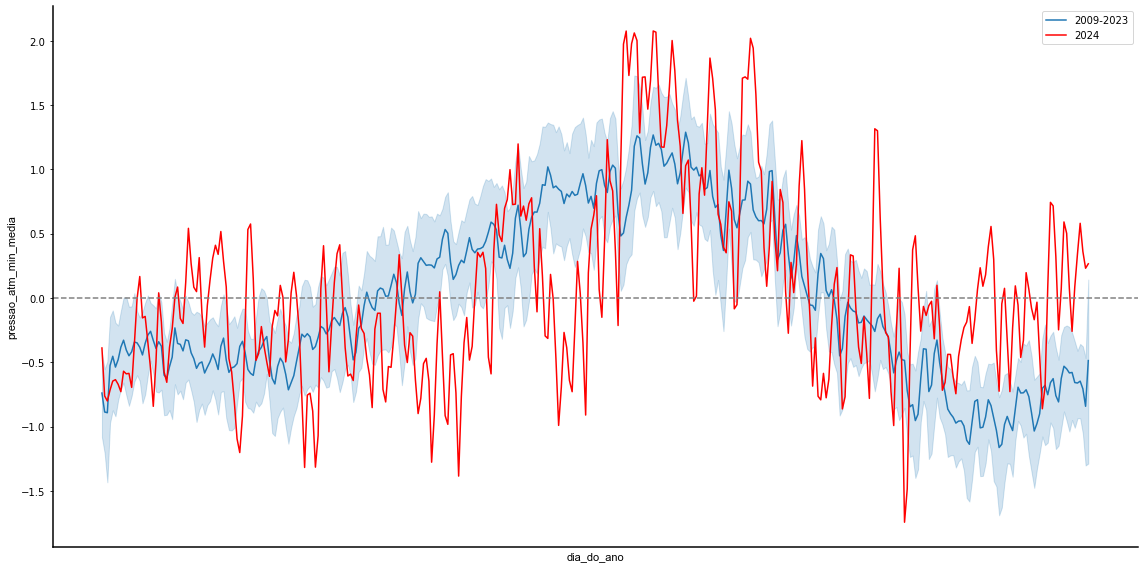

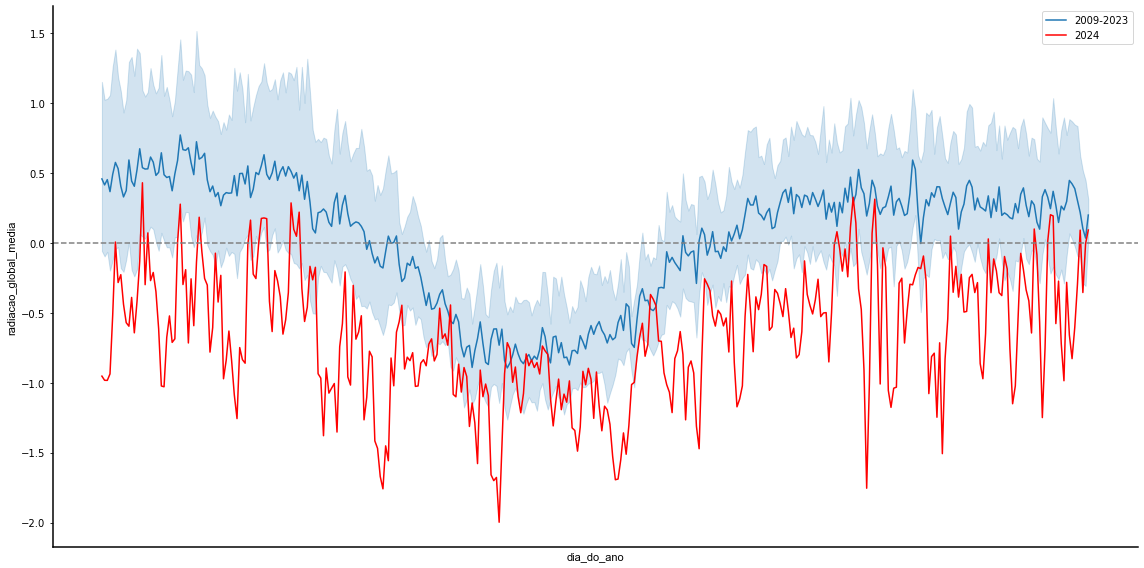

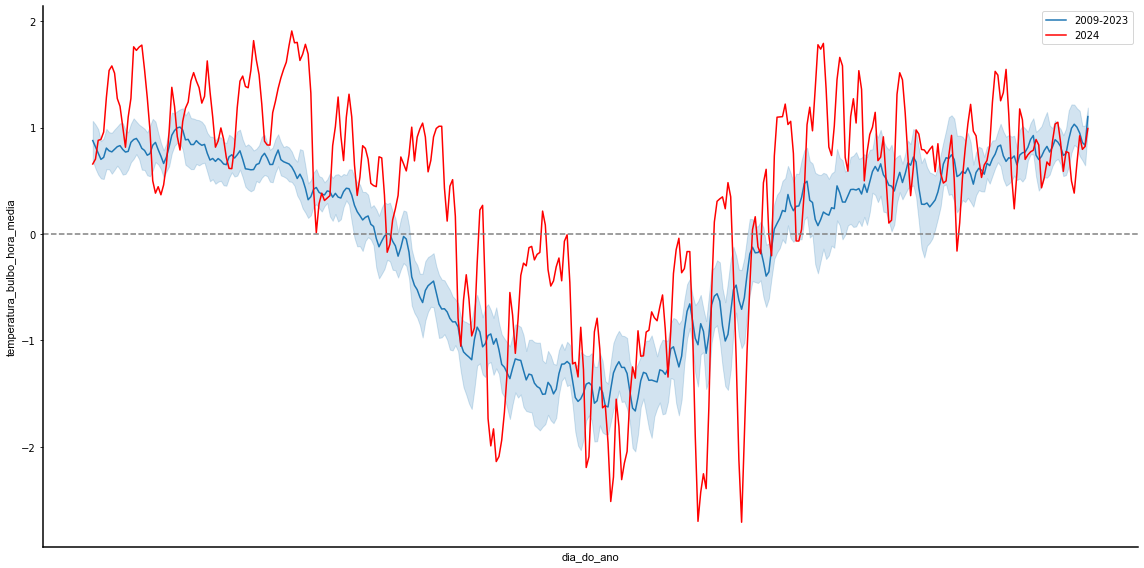

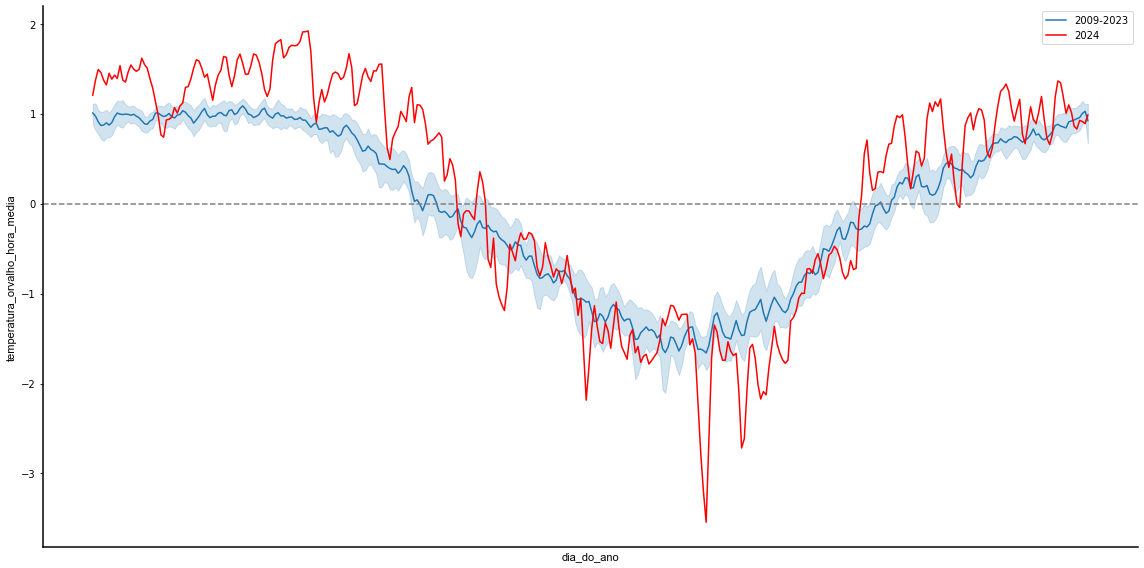

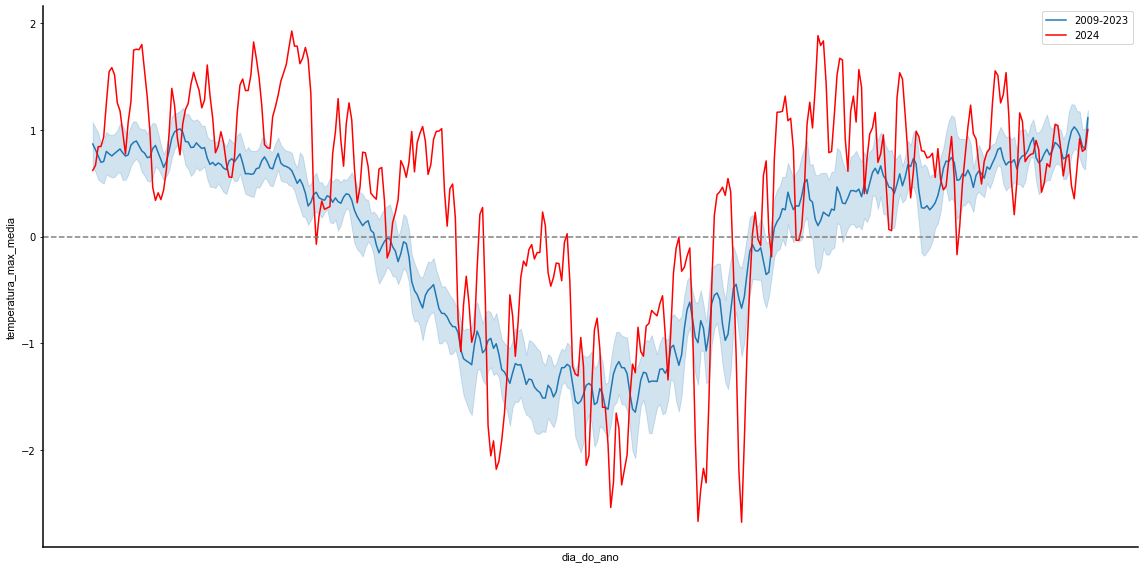

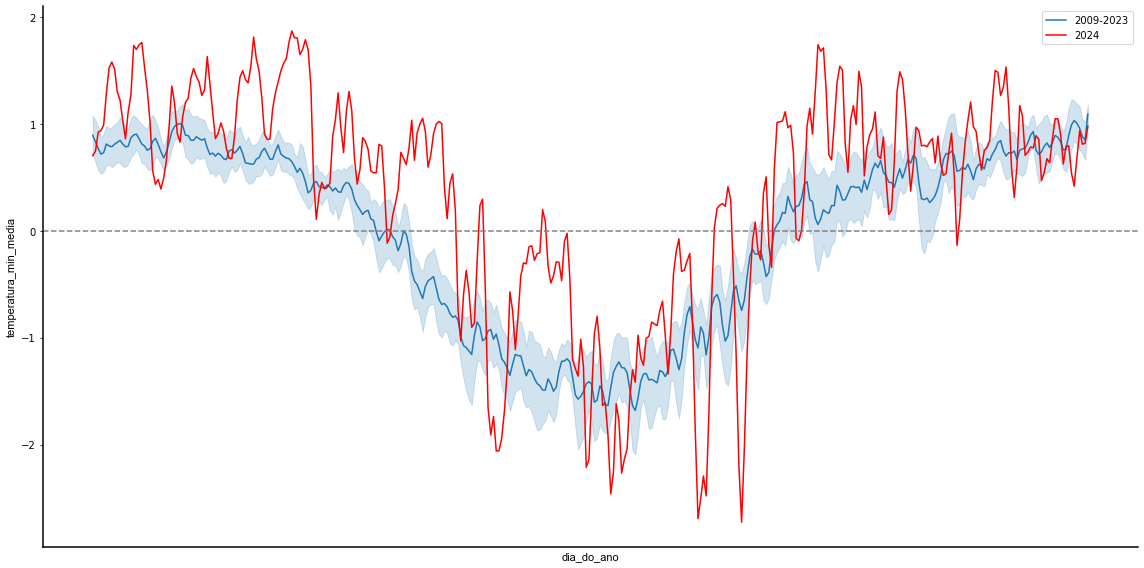

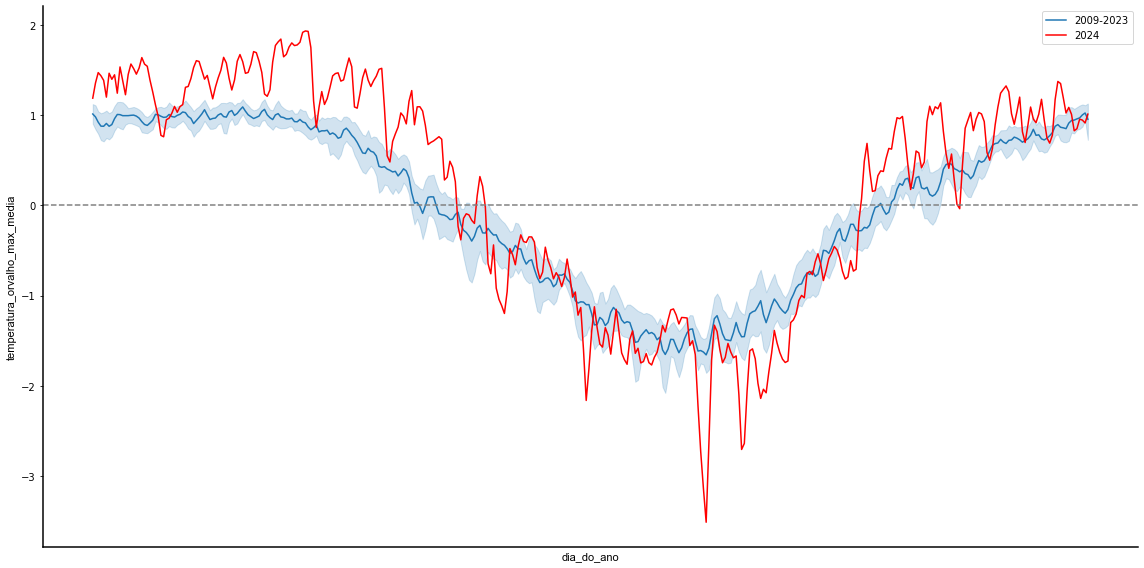

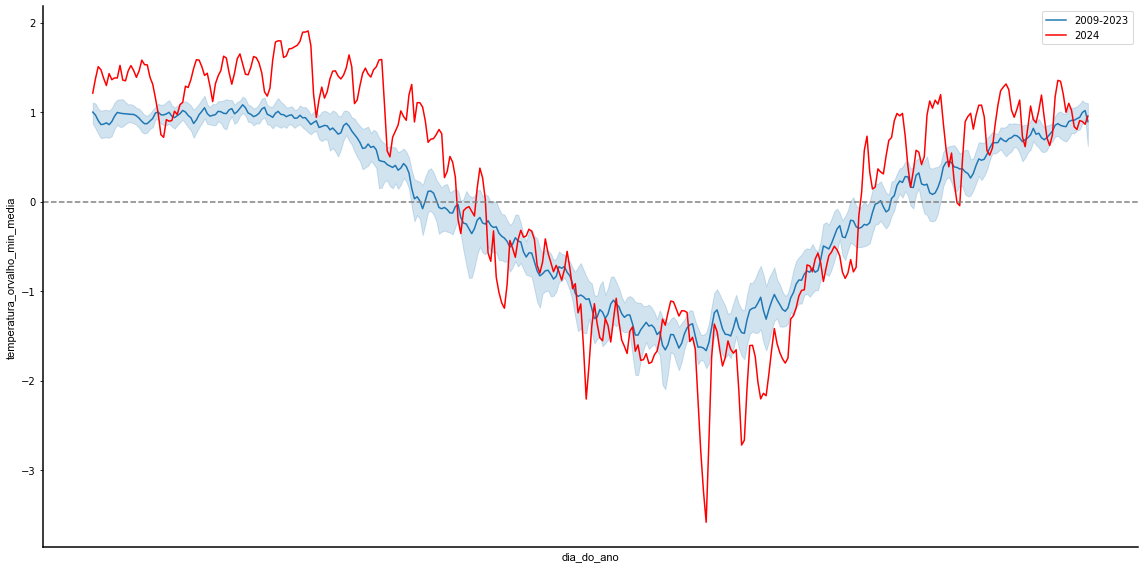

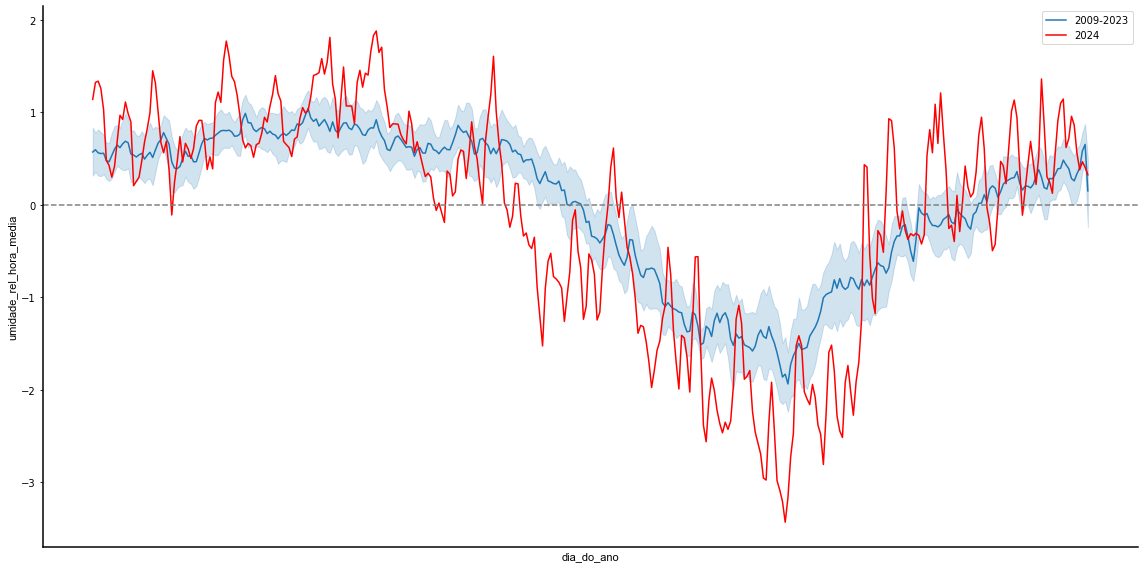

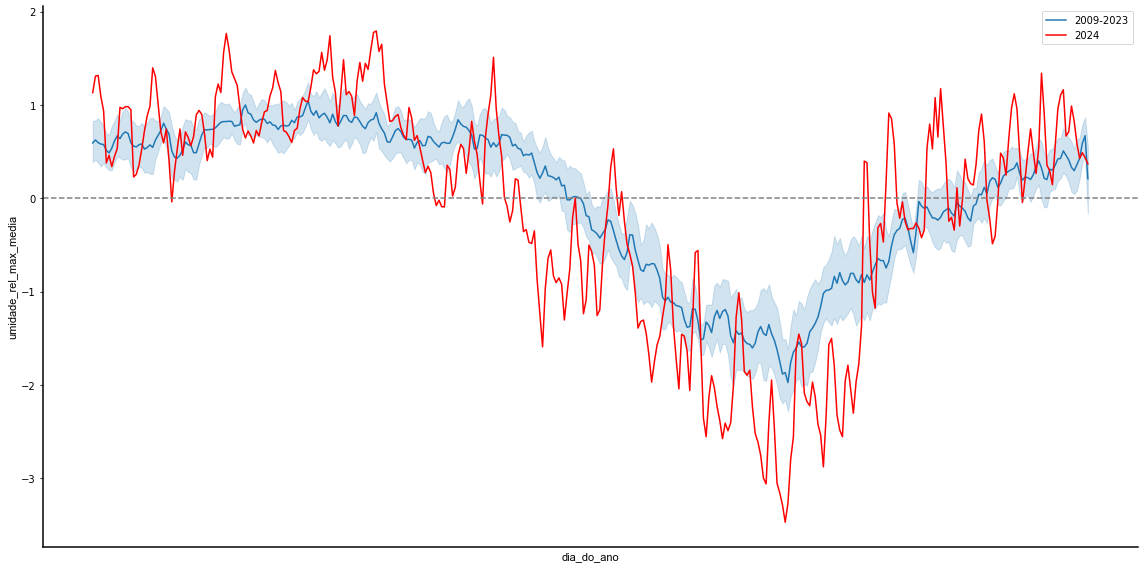

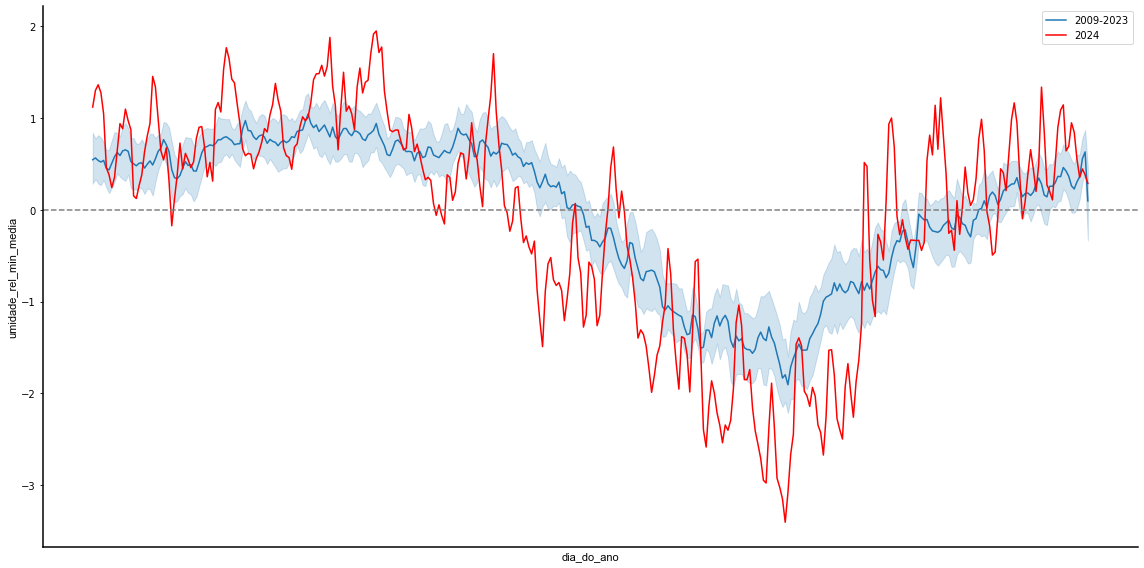

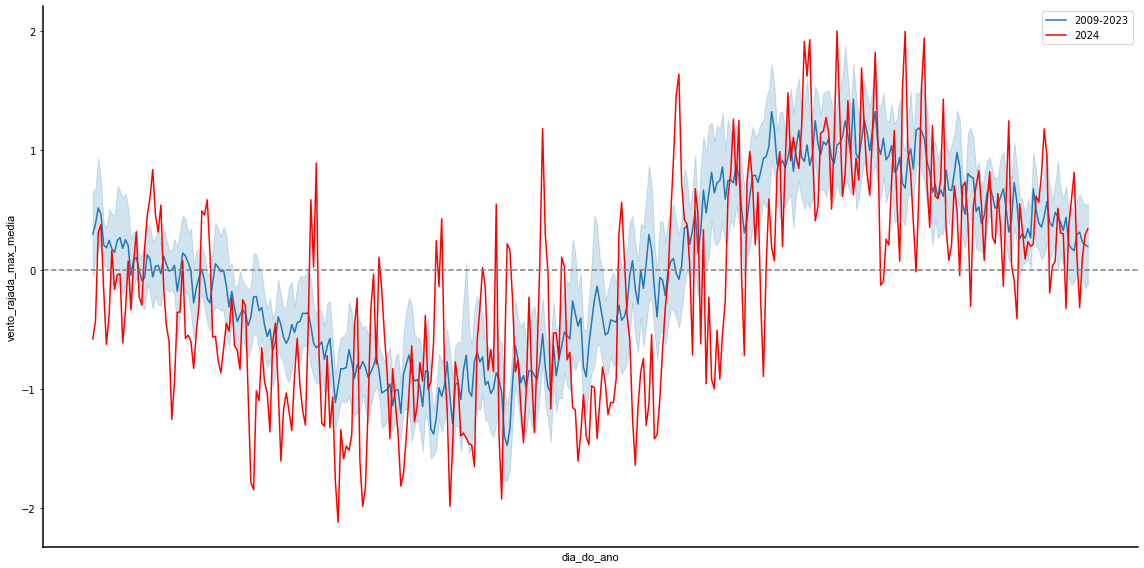

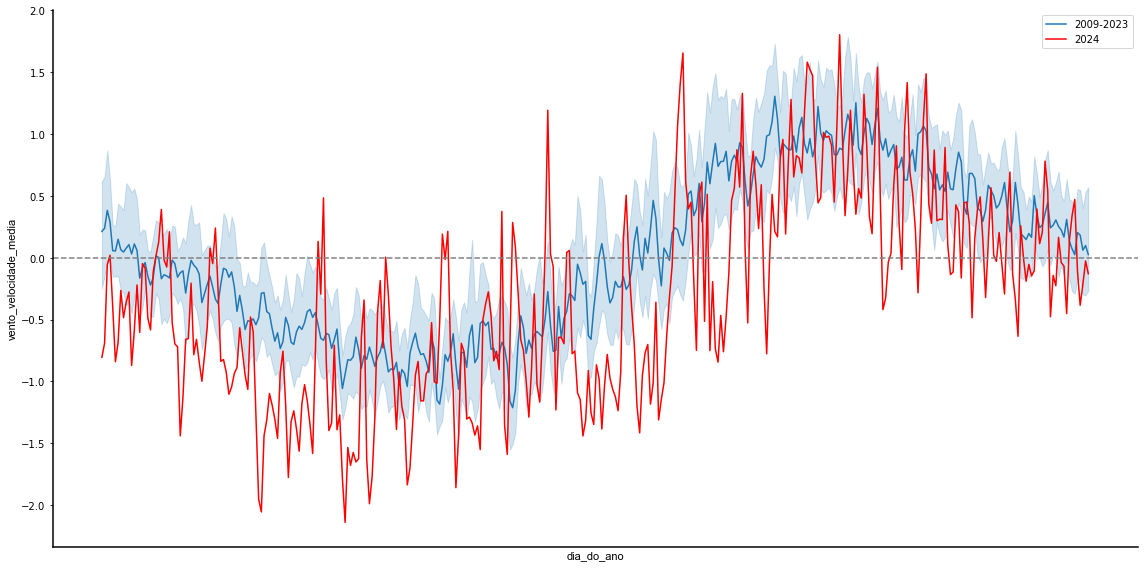

In [13]:
for feature in numerical_cols:
    feature_data = complete_data_scl[feature]
    feature_data = feature_data.reset_index()

    selected_years_data = feature_data[feature_data["ano"] != "2024"]
    last_year_data = feature_data[feature_data["ano"] == "2024"]

    fig, ax = plt.subplots(figsize=(16, 8))
    sns.lineplot(
    y=selected_years_data[feature], 
    x=selected_years_data["dia_do_ano"],
    label="2009-2023",
    ax=ax
)
    sns.lineplot(
        y=last_year_data[feature], 
        x=last_year_data["dia_do_ano"],
        color="red",
        label="2024",
        ax=ax
    )

    ax.axhline(0, color="gray", linestyle="--")
    ax.set_title('')
    ax.grid(False)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('black')

    ax.set_xlabel('dia_do_ano', fontsize=11, fontname='Arial', color='black')
    ax.set_ylabel(feature, fontsize=11, fontname='Arial', color='black')

    ax.set_xticks([])

    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    plt.tight_layout()
    plt.show()

## Correlação

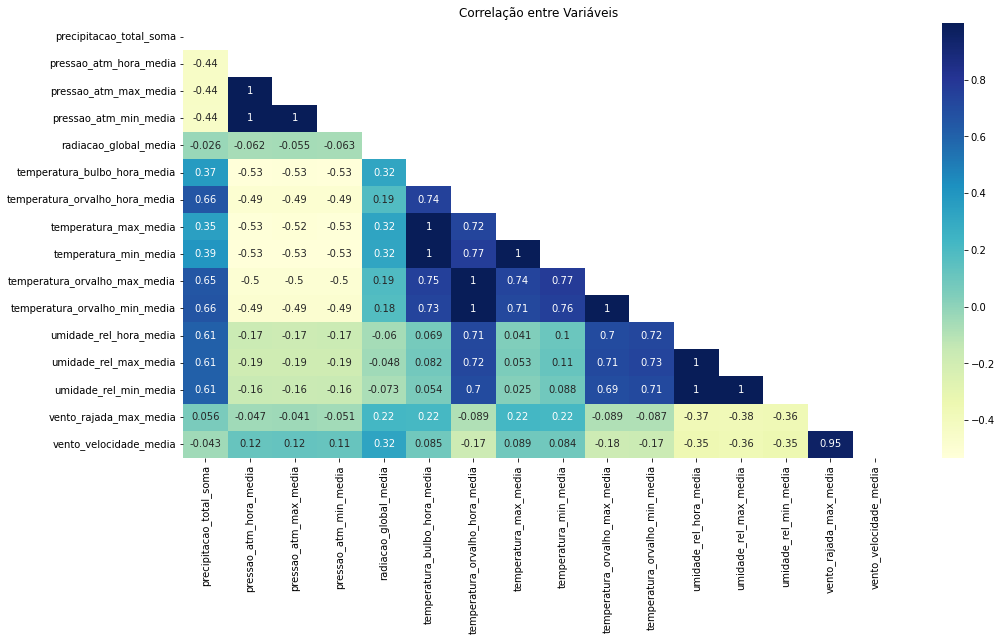

In [14]:
create_correlation_matrix(
    df=complete_data[numerical_cols],
    columns=numerical_cols
)

In [15]:
complete_data["indice_fenomenos"] = (
    complete_data["categoria_El Ninõ"] - complete_data["categoria_La Ninã"]) / (complete_data["categoria_El Ninõ"] + complete_data["categoria_La Ninã"])

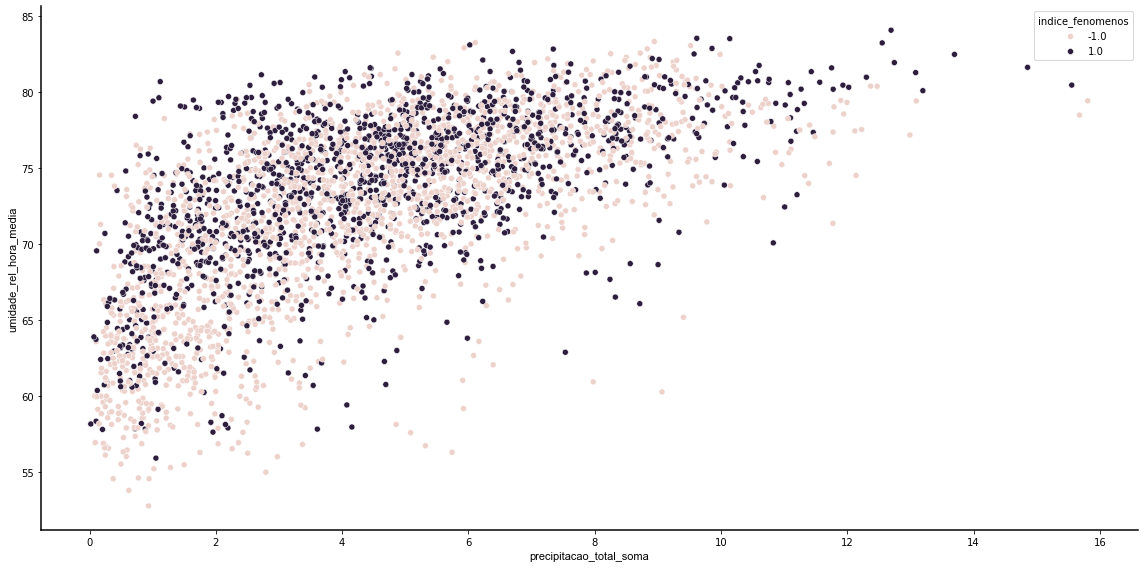

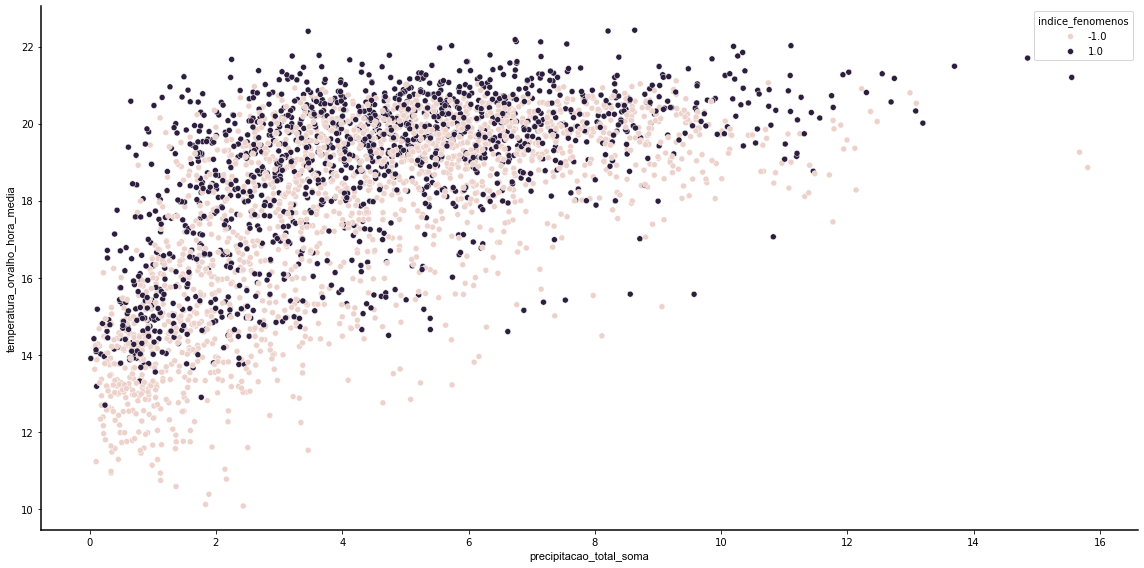

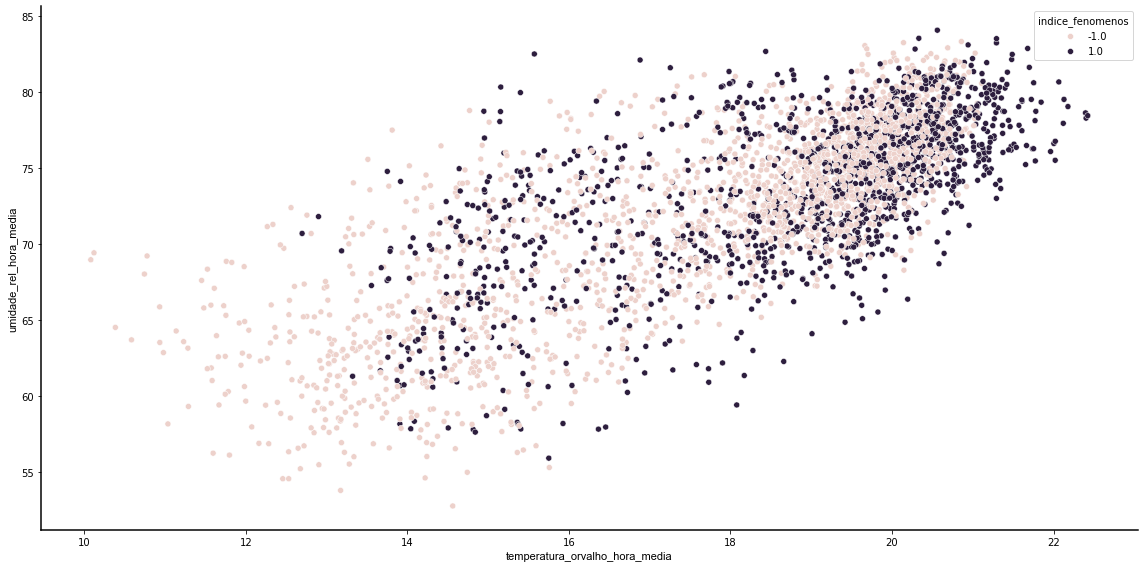

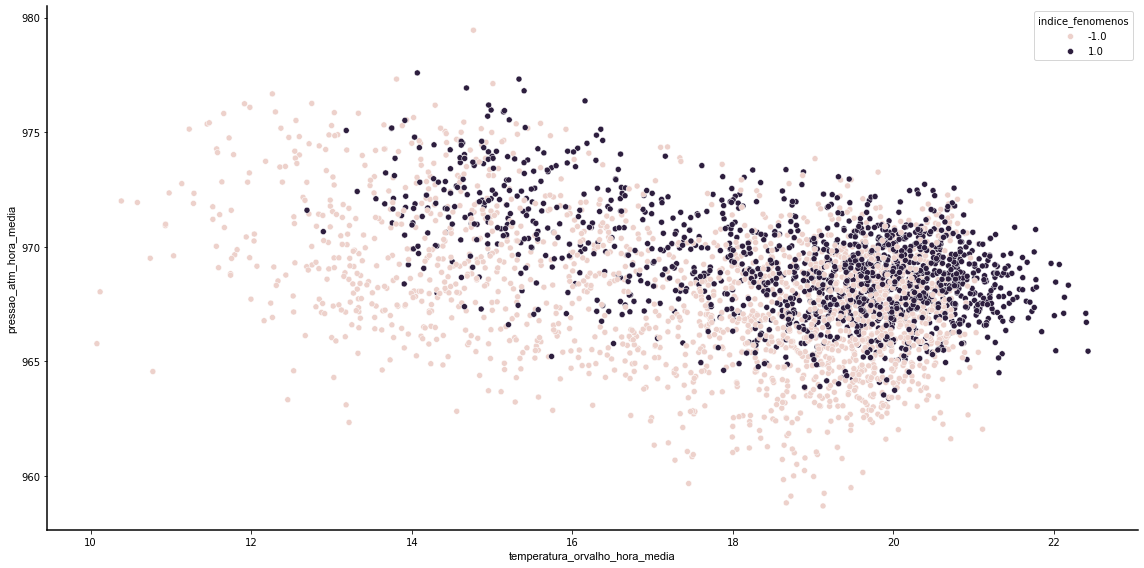

In [17]:
features_to_plot = [
    ("precipitacao_total_soma", "umidade_rel_hora_media"),
    ("precipitacao_total_soma", "temperatura_orvalho_hora_media"),
    ("temperatura_orvalho_hora_media", "umidade_rel_hora_media"),
    ("temperatura_orvalho_hora_media", "pressao_atm_hora_media")]

for feature_tuple in features_to_plot:

    x = feature_tuple[0]
    y = feature_tuple[1]

    plot_scatterplot(
        df=complete_data,
        x=x,
        y=y,
        hue="indice_fenomenos")

## Agregação Anual

In [18]:
yearly_data = complete_data.groupby("ano")[
    numerical_cols + ["categoria_El Ninõ", "categoria_La Ninã", "categoria_Neutro"]].mean()

In [19]:
yearly_data["indice_fenomenos"] = (
    yearly_data["categoria_El Ninõ"] - yearly_data["categoria_La Ninã"]) / (yearly_data["categoria_El Ninõ"] + yearly_data["categoria_La Ninã"])

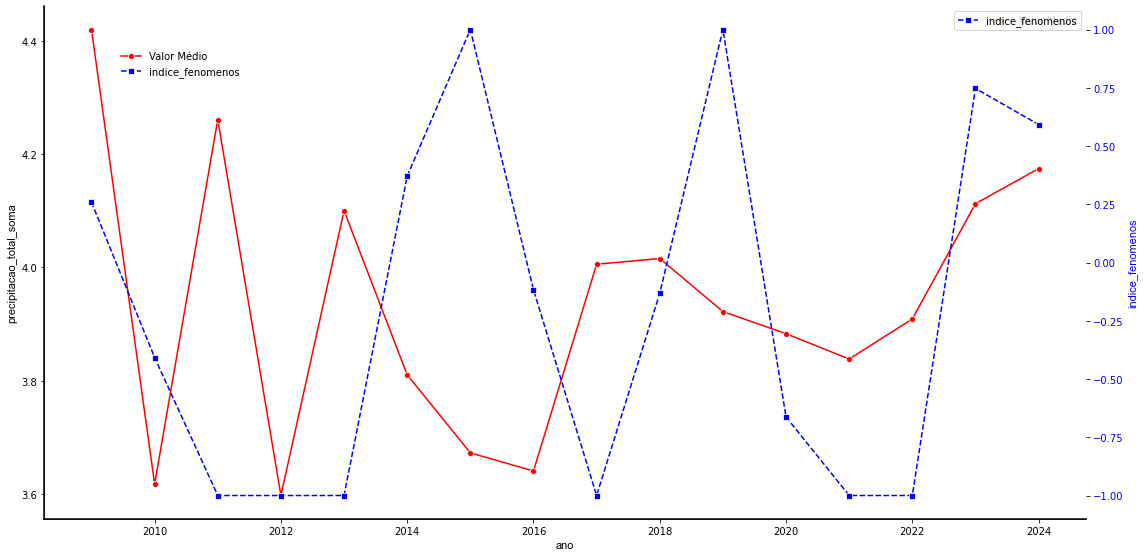

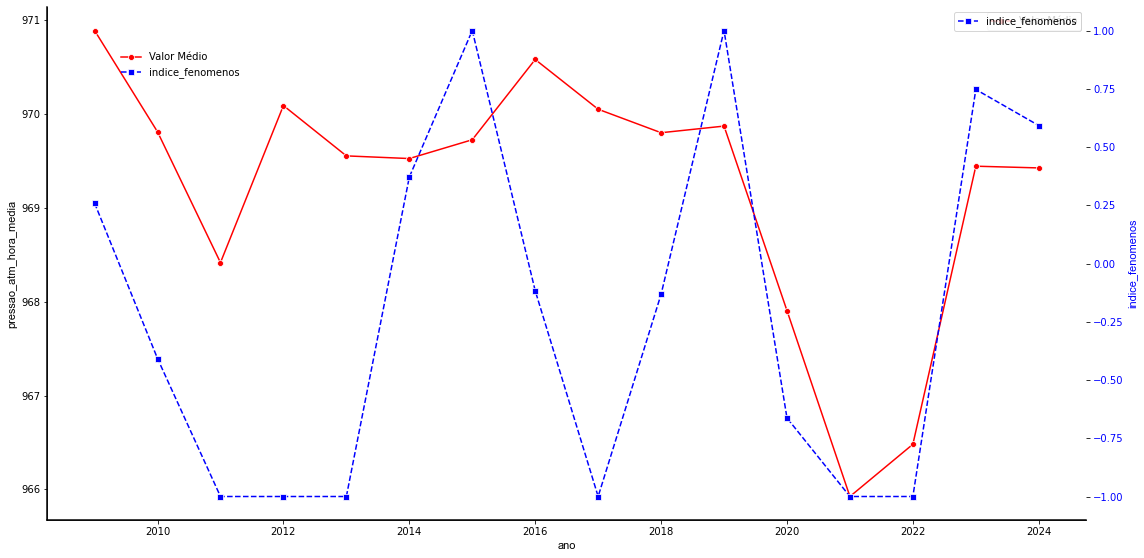

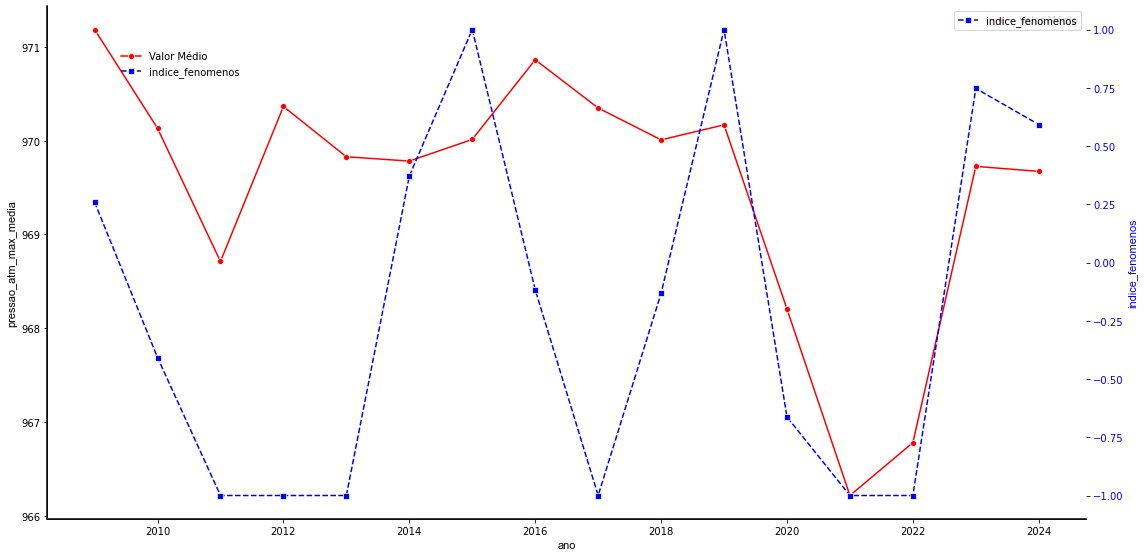

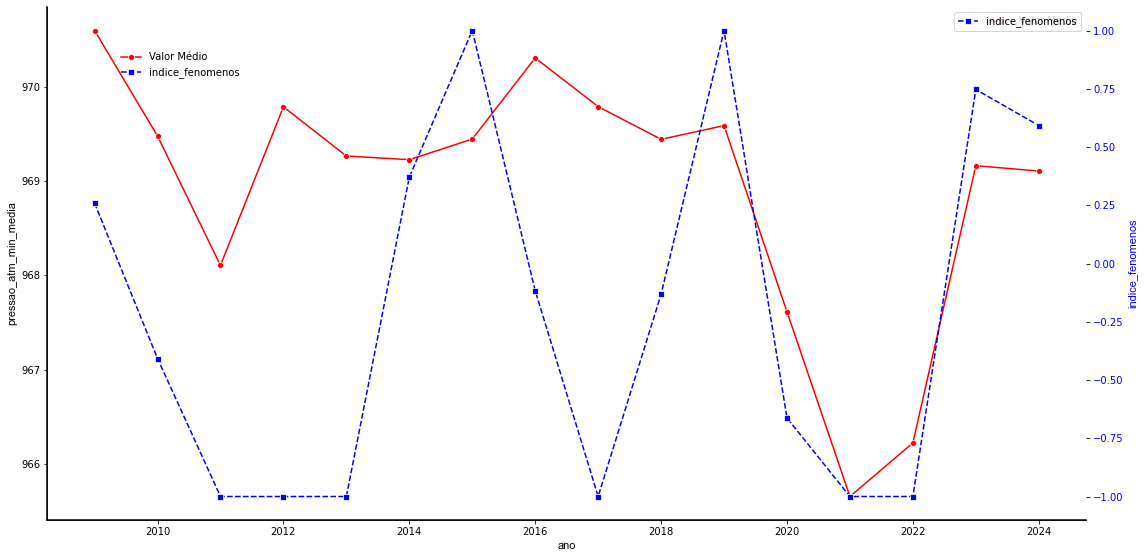

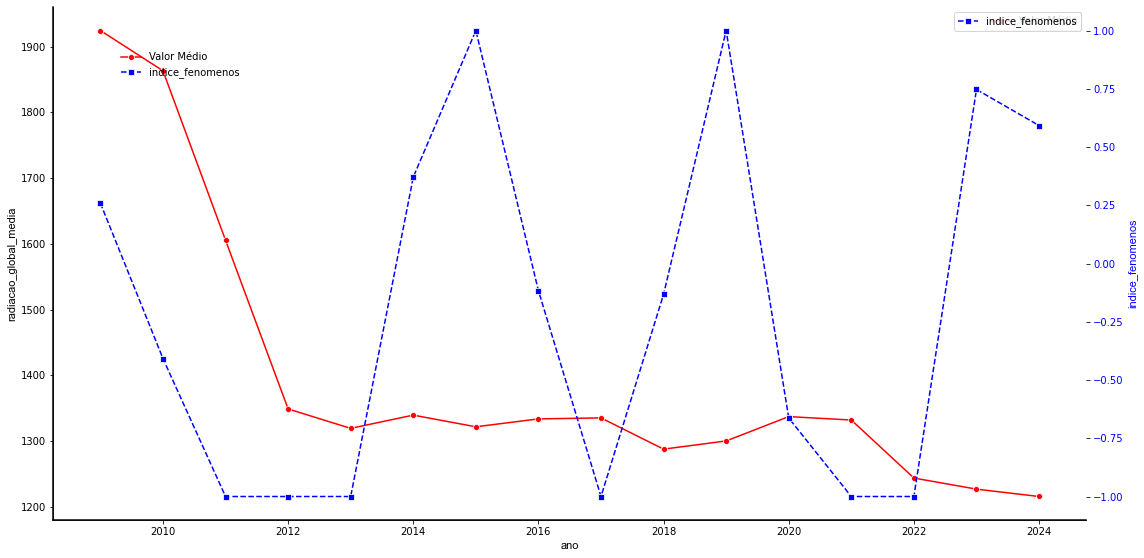

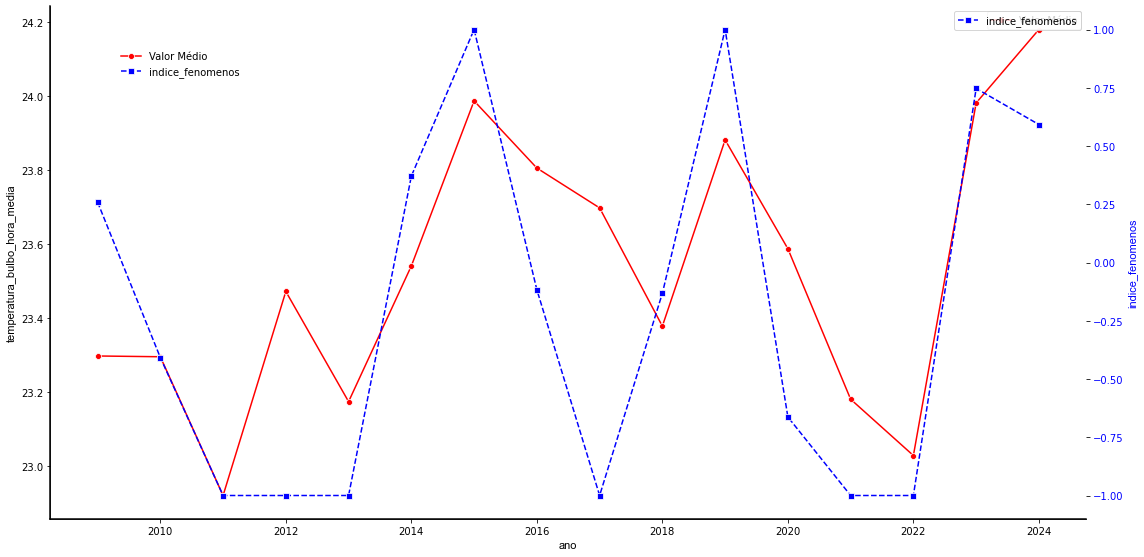

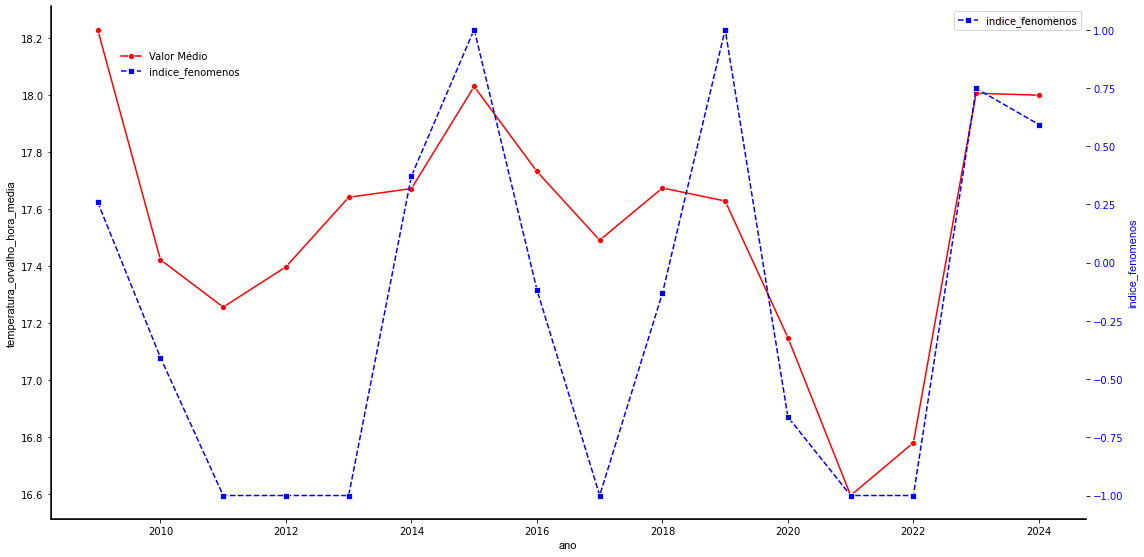

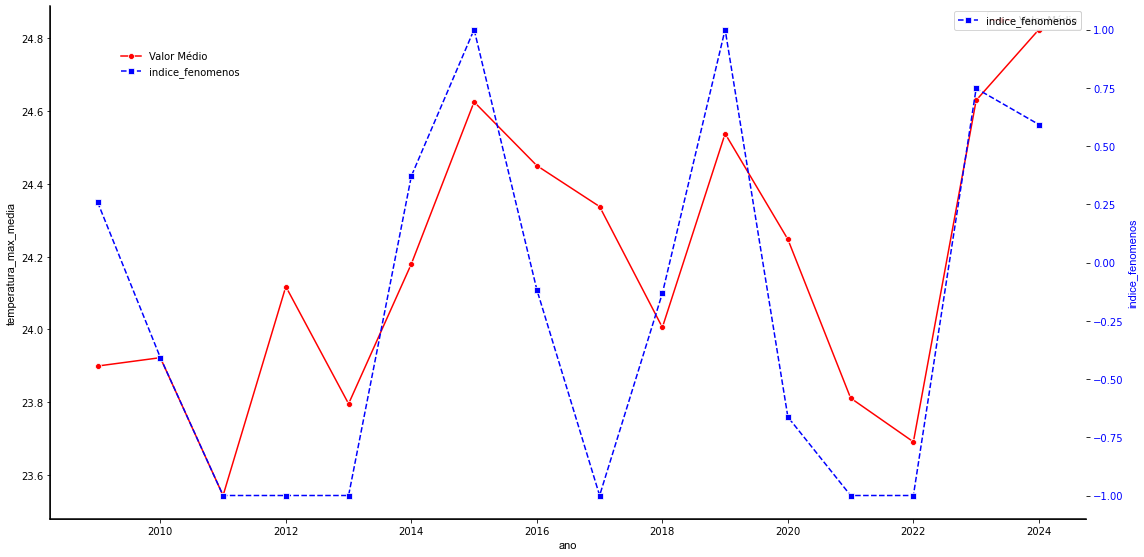

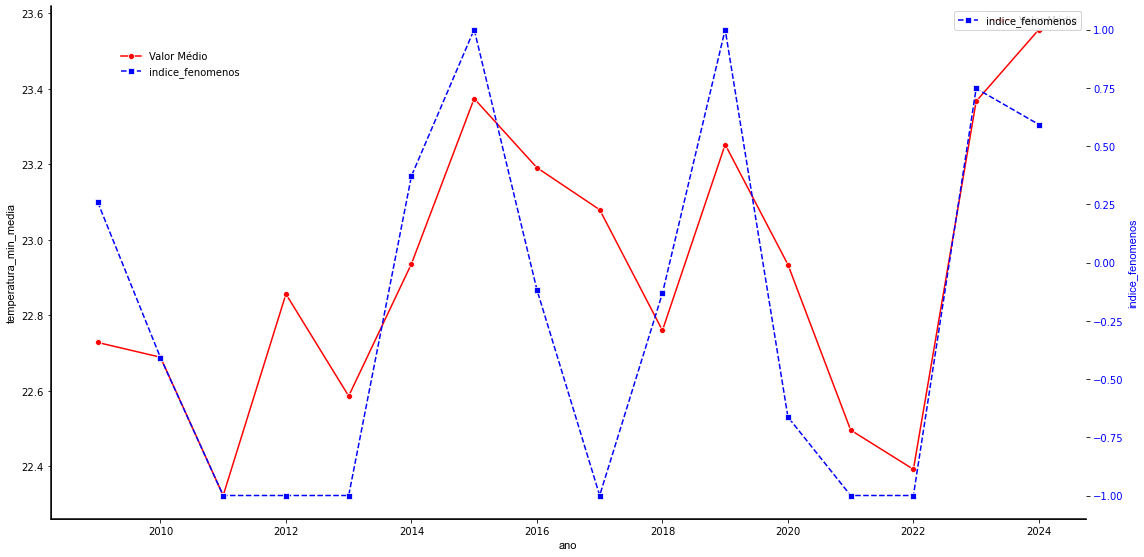

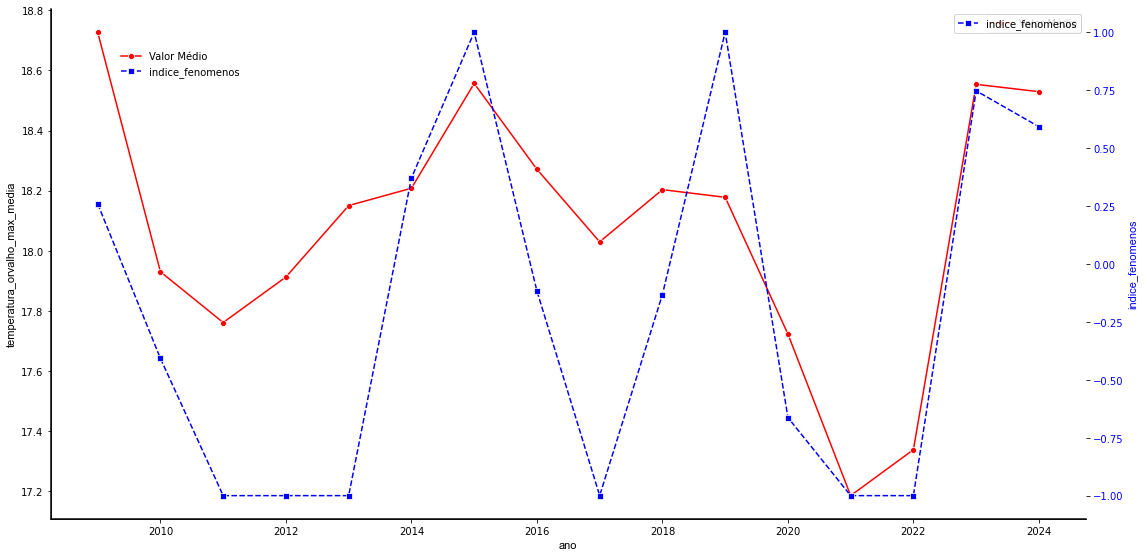

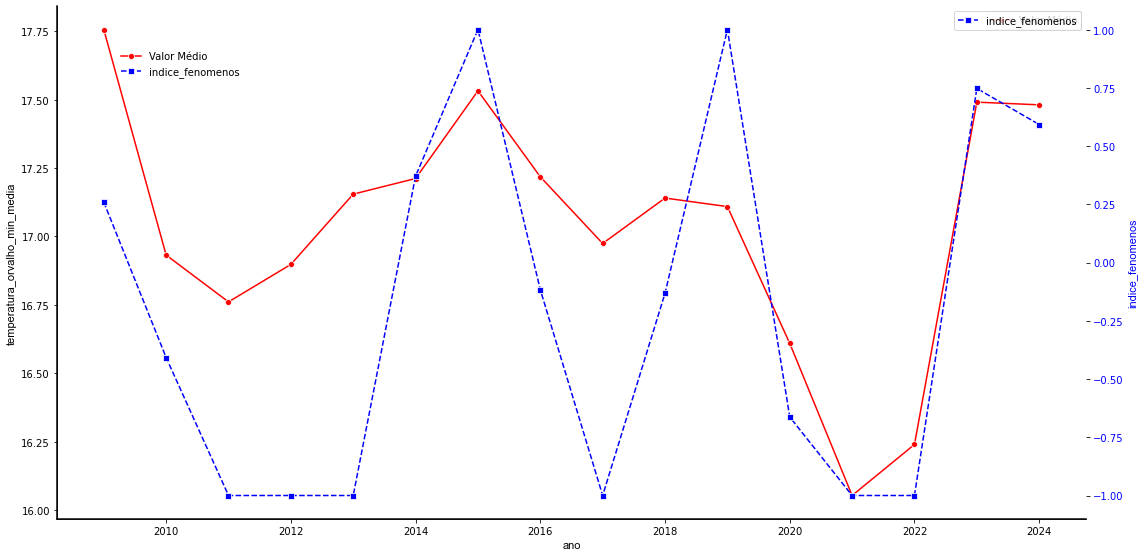

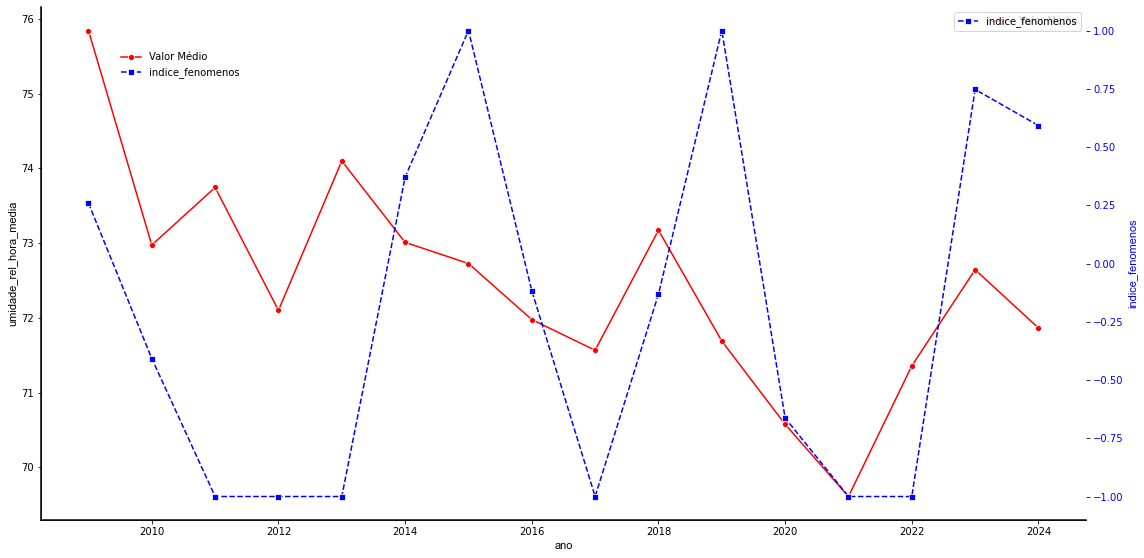

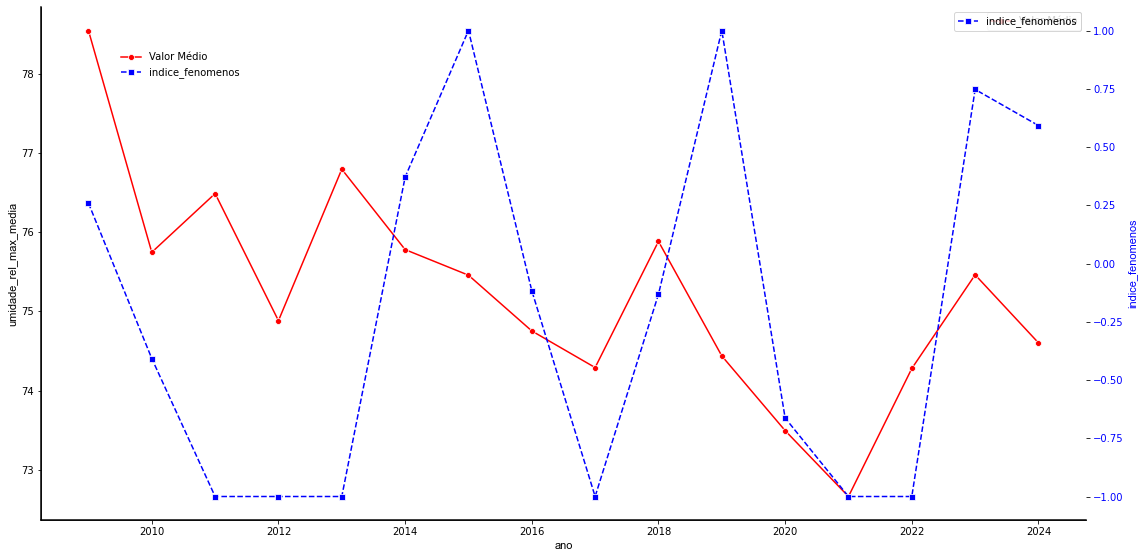

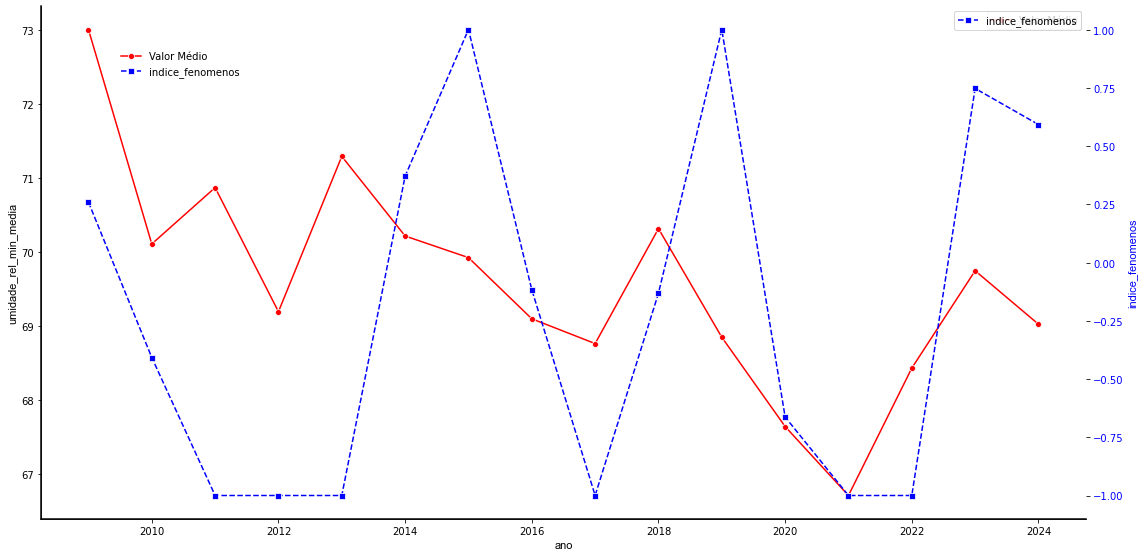

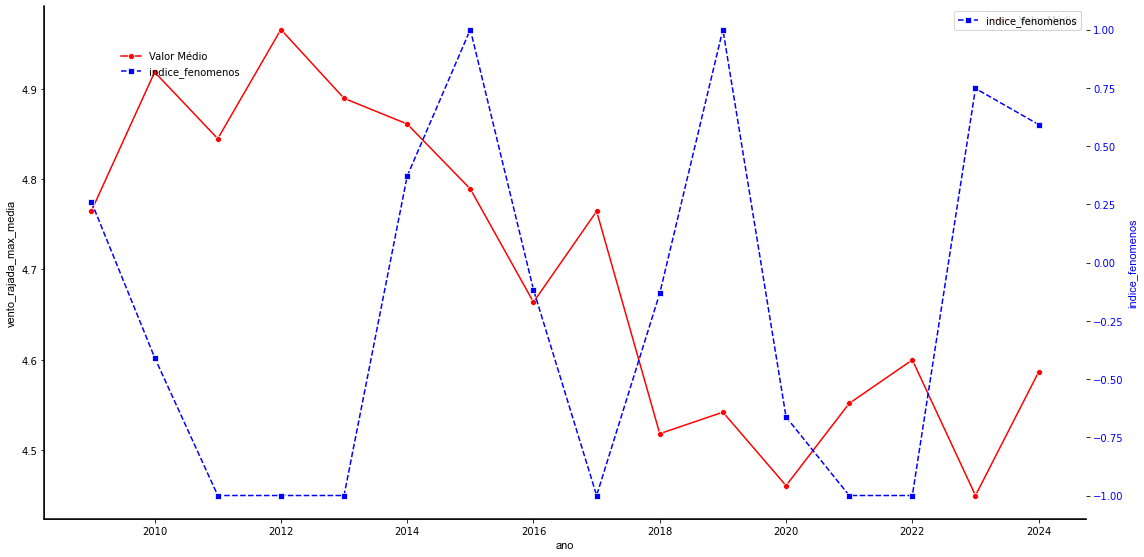

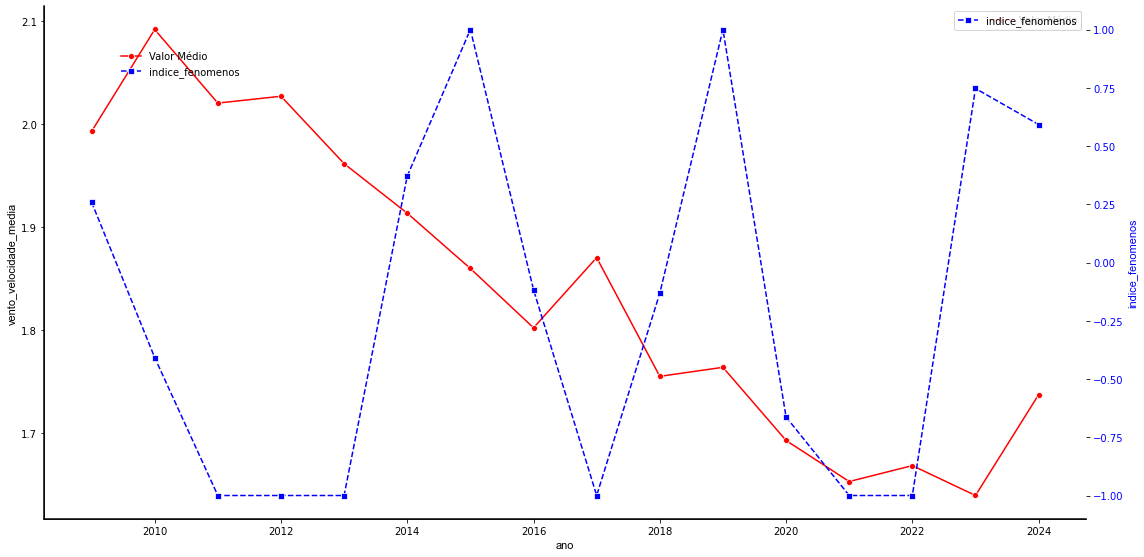

In [20]:
for feature in numerical_cols:
    feature_data = yearly_data[feature].reset_index()
    index_data = yearly_data["indice_fenomenos"].reset_index()
    
    fig, ax1 = plt.subplots(figsize=(16, 8))

    sns.lineplot(
    x=feature_data["ano"], 
    y=feature_data[feature], 
    ax=ax1,
    color="red",
    marker="o",
    label="Valor Médio")

    ax1.grid(False)

    for spine in ['top', 'right']:
        ax1.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax1.spines[spine].set_linewidth(1.5)
        ax1.spines[spine].set_color('black')

    ax1.set_xlabel("ano", fontsize=11, fontname='Arial', color='black')
    ax1.set_ylabel(feature, fontsize=11, fontname='Arial', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_facecolor('white')

    ax2 = ax1.twinx()
    sns.lineplot(
        x=index_data["ano"], 
        y=index_data["indice_fenomenos"], 
        ax=ax2,
        color="blue",
        marker="s",
        linestyle="dashed",
        label="indice_fenomenos"
    )

    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax2.set_ylabel("indice_fenomenos", fontsize=11, fontname='Arial', color='blue')
    ax2.tick_params(axis="y", labelcolor="blue")
    ax2.set_facecolor('white')

    fig.suptitle('')
    fig.patch.set_facecolor('white')
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9), frameon=False)

    plt.tight_layout()
    plt.show()

## Qualidade do Ar

In [21]:
data_quality_period = complete_data.loc[(complete_data["ano"] >= 2015) & (complete_data["ano"] <= 2022)]

In [22]:
data_quality_cols = ["CO", "MP10", "MP2.5", "O3", "SO2"]

In [23]:
data_quality_period

ano  mes       data  precipitacao_total_soma  pressao_atm_hora_media  \
2191  2015    1 2015-01-01                 5.659341              965.960673   
2192  2015    1 2015-01-02                 3.303297              966.552033   
2193  2015    1 2015-01-03                 3.476923              967.601729   
2194  2015    1 2015-01-04                 6.780220              968.489852   
2195  2015    1 2015-01-05                 4.329670              968.717265   
...    ...  ...        ...                      ...                     ...   
5108  2022   12 2022-12-27                 7.334091              967.373178   
5109  2022   12 2022-12-28                10.495455              967.212512   
5110  2022   12 2022-12-29                 8.650000              968.291805   
5111  2022   12 2022-12-30                 6.584091              968.388208   
5112  2022   12 2022-12-31                 5.604494              968.757753   

      pressao_atm_max_media  pressao_atm_min_media  radiacao_global_media  \
2191             966.269209             965.659349            1561.524031   
2192             966.811577             966.224048            1539.225222   
2193             967.884300             967.298015            1538.860247   
2194             968.765054             968.179852            1487.256037   
2195             968.979937             968.454880            1511.540797   
...                     ...                    ...                    ...   
5108             967.626684             967.098640            1112.857612   
5109             967.517448             966.923844            1175.361250   
5110             968.547515             968.009318            1279.894069   
5111             968.667086             968.144013            1284.851674   
5112             969.031274             968.488938            1352.080342   

      temperatura_bulbo_hora_media  temperatura_orvalho_hora_media  ...  \
2191                     25.991562                       19.905376  ...   
2192                     25.770911                       19.594555  ...   
2193                     25.287540                       19.556153  ...   
2194                     24.868958                       19.425306  ...   
2195                     24.826766                       19.492334  ...   
...                            ...                             ...  ...   
5108                     24.112798                       19.698552  ...   
5109                     24.139602                       19.707426  ...   
5110                     24.185117                       18.926701  ...   
5111                     24.444329                       18.796196  ...   
5112                     25.017207                       19.468923  ...   

      vento_velocidade_media  categoria_El Ninõ  categoria_La Ninã  \
2191                2.133650                  1                  0   
2192                1.909130                  1                  0   
2193                1.606264                  1                  0   
2194                1.782914                  1                  0   
2195                1.774863                  1                  0   
...                      ...                ...                ...   
5108                1.576389                  0                  1   
5109                1.827257                  0                  1   
5110                1.621288                  0                  1   
5111                1.514774                  0                  1   
5112                1.565653                  0                  1   

      categoria_Neutro   CO  MP10  MP2.5   O3  SO2  indice_fenomenos  
2191                 0  Boa   Boa    Boa  Boa  Boa               1.0  
2192                 0  Boa   Boa    Boa  Boa  Boa               1.0  
2193                 0  Boa   Boa    Boa  Boa  Boa               1.0  
2194                 0  Boa   Boa    Boa  Boa  Boa               1.0  
2195                 0  Boa   Boa   

In [24]:
data_quality_period_melted = data_quality_period.melt(id_vars=["data"], value_vars=data_quality_cols)

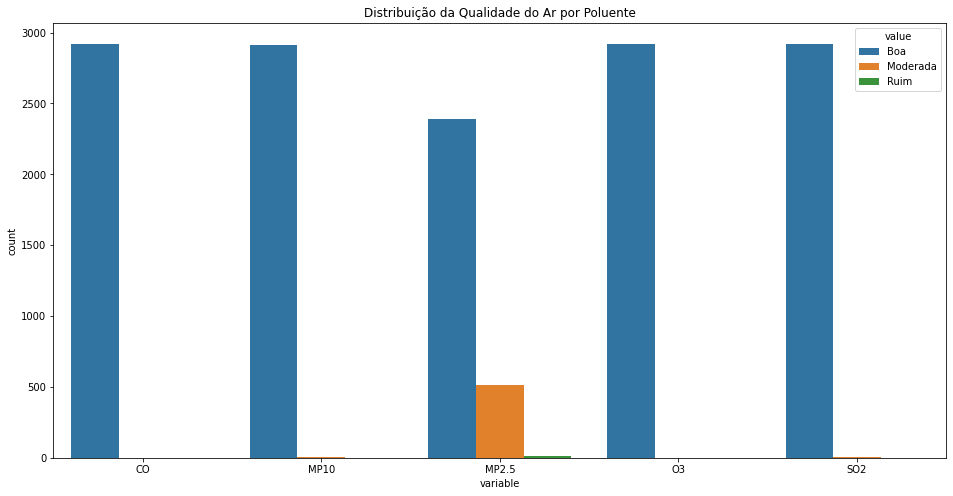

In [25]:
fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(
    data=data_quality_period_melted,
    x="variable",
    hue="value",
    ax=ax
)
plt.title("Distribuição da Qualidade do Ar por Poluente")
plt.show()

In [26]:
data_quality_period_melted.loc[data_quality_period_melted["value"] != "Boa"]

data variable     value
3188  2015-09-24     MP10  Moderada
3189  2015-09-25     MP10  Moderada
3210  2015-10-16     MP10  Moderada
4637  2019-09-12     MP10  Moderada
4643  2019-09-18     MP10  Moderada
...          ...      ...       ...
12611 2017-07-12      SO2  Moderada
12688 2017-09-27      SO2  Moderada
14113 2021-08-22      SO2  Moderada
14448 2022-07-23      SO2  Moderada
14450 2022-07-25      SO2  Moderada

[543 rows x 3 columns]